<font size="4">**SANTANDER CUSTOMER TRANSACTION PREDICTION**</font>

<font size="3">**Buisness Problem :-**
The problem is posed by Santander group, a financial services company looking for ways to help clients understand their financial health and identify which products and services might help them achieve their monetary goals. The transaction made by a customer is purely on one’s instinct and intuition, here the group is seeking Machine learning solution to help them identify which customer will make a specific transaction in the future, irrespective of the amount of money transacted. This is all to achieve the overall customer satisfaction.

The historical data related to past activity of the consumer can be used for predictive modeling that captures attributes to which may have great influence on future customer activity. This opens up the way for marketing department to come up with new strategies and optimized marketing campaigns, suited to customer needs which in turn enhances their experience. This significantly reduces the customer attrition rate and increases the customer life time value(LTV).</font>


**PERFORMANCE MATRIX**--
1)This is a binary classification problem having classes 0 and 1. we want to focus more on the minority class,
which is class 1. 
In case of class imbalance (which is this case) the ROC-AUC can be misleading because it looks at both 
the classes whereas the precision-Recall curve focuses only on the minority class. 
That's why Precisin-Recall curve and area under it will be  good fit here.

2) we can use Macro-averaged precison which treats all classes equally(we have class imbalance) instead of looking at only majority class. 
<br>3) Confusion matrix to see the classification's various distribution
<br>4)ROC-AUC 

In [4]:
import numpy as np
import pandas as pd
from scipy.special import logit
from sklearn.metrics import roc_auc_score,roc_curve, precision_recall_curve, auc,confusion_matrix,precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.special import logit
import warnings
warnings.filterwarnings("ignore") 

In [5]:
train_df=pd.read_csv(r'C:\Users\Debashish\AAIC assignments\Self case study-1\train.csv')
test_df=pd.read_csv(r'C:\Users\Debashish\AAIC assignments\Self case study-1\test.csv')
train_df_new=train_df.copy()
test_df_new=test_df.copy()

So till now we have seen that this is a class imbalance problem and by doing EDA we came to know that  many of the features are following almost gaussian distribution.
Some of the features looks like bimodal distribution.By violin plot analysis with respect to target, we found that the plots more or less look same and also there isn't any extreme outliers with these variables. By removing these outliers we may loose important information and we have to use all of the features.
<br> By bi-variate analysis we see that the datapoints are not easily seperable and they are over-lapping a lot and there is a very small co-relation between features.
<br>**Feature engineering**:-
By doing analysis of the data we see that there is a difference in the maximum values between both classes.
<br>Kurtosis values for target==1 is slightly less than taget==0. There is a overlap between the two distributions.Kurtosis identifies weather the tails of the distributions contains extreme values and is used as a measure of financial risk(weather there is a probability of extremely large or exteremely samall returns). The difference of kurtosis plot is a right skewed i.e. a lot of differences are actually small but some of the differences are large too.
<br>The distribution of their variance difference curve is a left skewed curve and almost entire curve is on the negative side. This means the target==0 liklyhood distributions are more concentrated around their mean than the target==1 ones (we are subtracting target=0 - target=1).
so we are going to add some aggregated features to our model.

In [6]:
columns=train_df.drop(['ID_code','target'],axis=1).columns.values
fea_names=np.array([x for x in train_df.drop(labels=['ID_code','target'],axis=1).columns])

In [7]:
#Adding some aggregate features to our train data
train_df['max_val']=train_df[columns].max(axis=1)
train_df['std_dev']=train_df[columns].std(axis=1)
train_df['skew']=train_df[columns].skew(axis=1)
train_df['kurtosis']=train_df[columns].kurtosis(axis=1)
train_df['sum']=train_df[columns].sum(axis=1)
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_195,var_196,var_197,var_198,var_199,max_val,std_dev,skew,kurtosis,sum
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,-2.3978,7.8784,8.5635,12.7803,-1.0914,43.1127,9.331540,0.101580,1.331023,1456.3182
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,2.0339,8.1267,8.7889,18.3560,1.9518,40.5632,10.336130,-0.351734,4.110215,1415.3636
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,3.1417,-6.5213,8.2675,14.7222,0.3965,33.8820,8.753387,-0.056957,0.546438,1240.8966
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,-1.2706,-2.9275,10.2922,17.9697,-8.9996,38.1015,9.594064,-0.480116,2.630499,1288.2319
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.5121,3.9267,9.5031,17.9974,-8.8104,41.1037,11.287122,-1.463426,9.787399,1354.2310


In [ ]:
#Adding the same aggregate features to our test data
columns=test_df.drop(['ID_code'],axis=1).columns.values
test_df['max_val']=test_df[columns].max(axis=1)
test_df['std_dev']=test_df[columns].std(axis=1)
test_df['skew']=test_df[columns].skew(axis=1)
test_df['kurtosis']=test_df[columns].kurtosis(axis=1)
test_df['sum']=test_df[columns].sum(axis=1)
test_df.head()

In [8]:
#Splitting train data into train and validation dataset in 80:20 ratio. 
x_train=train_df.drop(['ID_code','target'],axis=1)
y_train=train_df['target'].values
x_train,x_v,y_train,y_v= train_test_split(x_train, y_train, test_size=0.2, stratify=y_train,random_state=0) #splitting into train and validation set
print(x_train.shape,y_train.shape)

(160000, 205) (160000,)


In [6]:
# Standardizing out train and validate data sets using standard scaler.
std=StandardScaler()
x_train=std.fit_transform(x_train)
x_v=std.transform(x_v)
x_test=test_df.drop(['ID_code'],axis=1)
x_test=std.transform(x_test)

<font size="4">**MACHINE LEARNING MODELS**</font>
<br><font size="3">**Base-line model**</font>

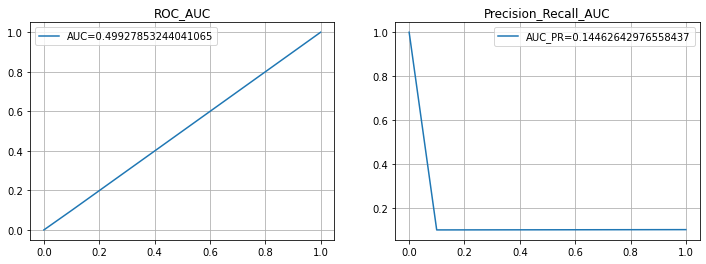

In [ ]:
#creating a base line model which just predict 0 or 1 randomly.
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier(strategy='stratified')
dummy.fit(x_train,y_train)
y_pred=dummy.predict_proba(x_train)
fpr,tpr,th=roc_curve(y_train,y_pred[:,1])
precision,recall,threshold=precision_recall_curve(y_train,y_pred[:,1])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('ROC_AUC')
plt.plot(fpr,tpr,label='AUC='+str(auc(fpr,tpr)))
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.title('Precision_Recall_AUC')
plt.plot(recall,precision,label='AUC_PR='+str(auc(recall,precision)))
plt.grid()
plt.legend()
plt.show()

As expected our ROC_AUC of random model score came out to be 0.499(=0.5) as roc score of a random classifier is 0.5. The precision_Recall curve score is quite low(=0.144). If any of the machine learning model shows scores less than these scores than basically it is predicting worse than a random model.

[ ]
1


In [11]:
def plot_conclusions(y_tr,y_te,y_trpred,y_tepred,y_tpred):
    #fpr,tpr,th=roc_curve(y,y_pred[:,1])
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_trpred[:,1])
    test_fpr, test_tpr, te_thresholds = roc_curve(y_te, y_tepred[:,1])

    train_pre,train_re,tr_threshold=precision_recall_curve(y_tr, y_trpred[:,1])
    test_pre,test_re,te_threshold=precision_recall_curve(y_te, y_tepred[:,1])
    print('The precision score on test data= ',precision_score(y_te,y_tpred))
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.title('ROC_AUC')
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.legend()
  
    plt.subplot(1,2,2)
    plt.title('Precision_Recall_AUC')
    plt.plot(train_re,train_pre,label='train_AUC_PR='+str(auc(train_re,train_pre)))
    plt.plot(test_re,test_pre,label='test_AUC_PR='+str(auc(test_re,test_pre)))
    plt.xlabel('Recall')
    plt.ylabel("Precision")
    plt.grid()
    plt.legend()
  
    plt.figure(2)
    conf_mat=confusion_matrix(y_te,y_tpred)
    ax=plt.subplot()
    sns.heatmap(conf_mat,fmt='d',annot=True,cmap='Blues',ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels'); 
    ax.set_ylim(2.0, 0)
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['0','1']) 
    ax.yaxis.set_ticklabels(['0','1'])
    plt.show()
    return

**Logistic Regression**

In [14]:
lr=LogisticRegression(class_weight='balanced')
param_grid={'C': [0.001,0.01,0.1,1,10,100,1000]}
clf = GridSearchCV(lr,param_grid,cv=10,scoring='average_precision',verbose=3,n_jobs=-1,return_train_score=True)
clf.fit(x_train , y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='average_precision', verbose=3)

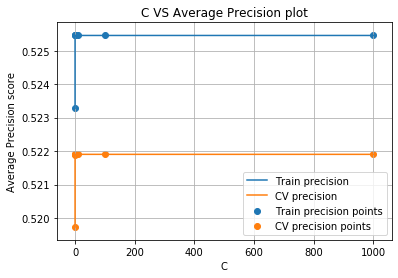

LogisticRegression(C=0.1, class_weight='balanced')
Average Precision score=  0.5219058780987099


In [15]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])
train_precision= results['mean_train_score']
cv_precision = results['mean_test_score']
C =  results['param_C']

plt.plot(C,train_precision, label='Train precision')
plt.plot(C,cv_precision, label='CV precision')
plt.scatter(C, train_precision, label='Train precision points')
plt.scatter(C, cv_precision,label='CV precision points')

plt.legend()
plt.xlabel("C")
plt.ylabel("Average Precision score")
plt.title("C VS Average Precision plot")
plt.grid()
plt.show()
b=clf.best_estimator_
print(b)
print('Average Precision score= ', clf.best_score_)

In [8]:
logistic=LogisticRegression(C=0.1,class_weight='balanced',n_jobs=-1)
logistic.fit(x_train,y_train)
y_train_pred = logistic.predict_proba(x_train)
y_test_pred = logistic.predict_proba(x_v)
y_tpred=logistic.predict(x_v)

The precision score on test data=  0.2925258934403285


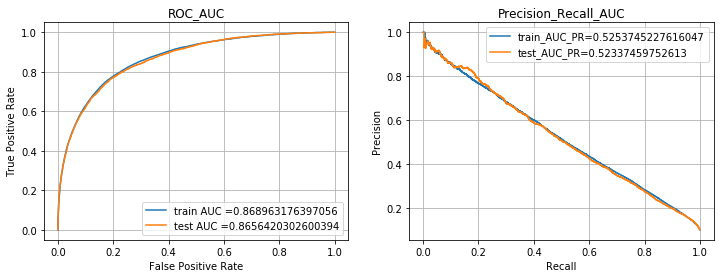

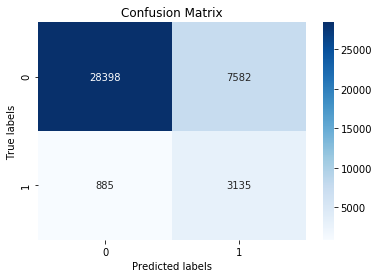

In [10]:
plot_conclusions(y_train, y_v, y_train_pred , y_test_pred,y_tpred)

In [9]:
#for kaggle submission
predicted_data=pd.DataFrame()
predicted_data['ID_Code']=test_df['ID_code']
predicted_data['target']=logistic.predict_proba(x_test)[:,1]
predicted_data.to_csv('Logistic_submission.csv',index=False)

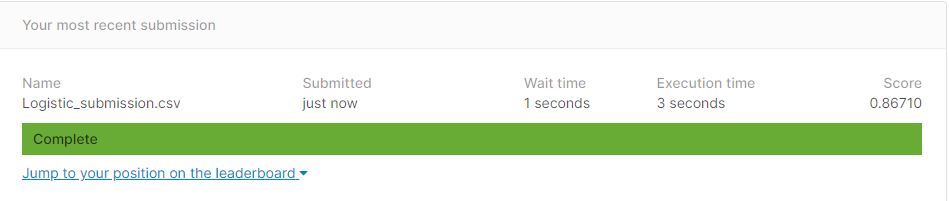


**Gaussian naive bayes**

In [ ]:
x=np.logspace(0,-15, num=15)
print(x)

[1.00000000e+00 8.48342898e-02 7.19685673e-03 6.10540230e-04
 5.17947468e-05 4.39397056e-06 3.72759372e-07 3.16227766e-08
 2.68269580e-09 2.27584593e-10 1.93069773e-11 1.63789371e-12
 1.38949549e-13 1.17876863e-14 1.00000000e-15]


In [11]:
nb=GaussianNB()
param = {'var_smoothing': np.logspace(0,-15, num=20)}
clf = GridSearchCV(nb,param,cv=10,scoring='average_precision',verbose=3,n_jobs=-1,return_train_score=True)
clf.fit(x_train , y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 1.62377674e-01, 2.63665090e-02, 4.28133240e-03,
       6.95192796e-04, 1.12883789e-04, 1.83298071e-05, 2.97635144e-06,
       4.83293024e-07, 7.84759970e-08, 1.27427499e-08, 2.06913808e-09,
       3.35981829e-10, 5.45559478e-11, 8.85866790e-12, 1.43844989e-12,
       2.33572147e-13, 3.79269019e-14, 6.15848211e-15, 1.00000000e-15])},
             return_train_score=True, scoring='average_precision', verbose=3)

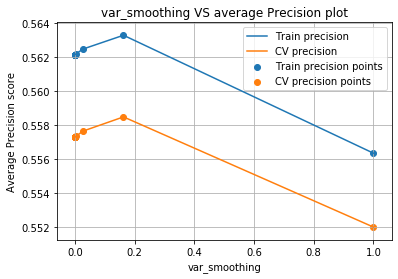

GaussianNB(var_smoothing=0.16237767391887217)
Average Precision score=  0.5584651584805704


In [13]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_var_smoothing'])
train_precision= results['mean_train_score']
cv_precision = results['mean_test_score']
C =  results['param_var_smoothing']

plt.plot(C,train_precision, label='Train precision')
plt.plot(C,cv_precision, label='CV precision')
plt.scatter(C, train_precision, label='Train precision points')
plt.scatter(C, cv_precision,label='CV precision points')

plt.legend()
plt.xlabel("var_smoothing")
plt.ylabel("Average Precision score")
plt.title("var_smoothing VS average Precision plot")
plt.grid()
plt.show()
b=clf.best_estimator_
print(b)
print('Average Precision score= ', clf.best_score_)

In [11]:
NB=GaussianNB(var_smoothing=0.16)
NB.fit(x_train,y_train)
y_train_pred = NB.predict_proba(x_train)
y_test_pred = NB.predict_proba(x_v)
y_tpred=NB.predict(x_v)

The precision score on test data=  0.8424479166666666


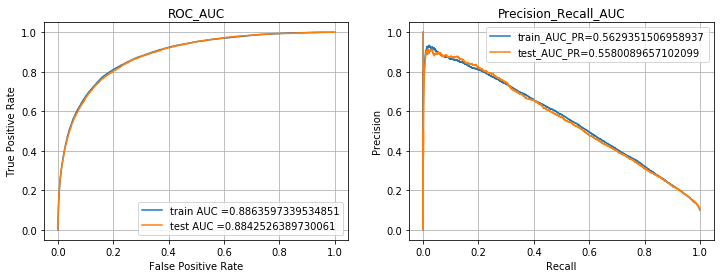

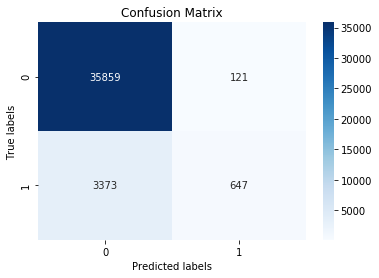

In [12]:
plot_conclusions(y_train, y_v, y_train_pred , y_test_pred,y_tpred)

In [13]:
#for kaggle submission
data=pd.DataFrame()
data['ID_Code']=test_df['ID_code']
data['target']=NB.predict_proba(x_test)[:,1]
data.to_csv('Naive_submission.csv',index=False)

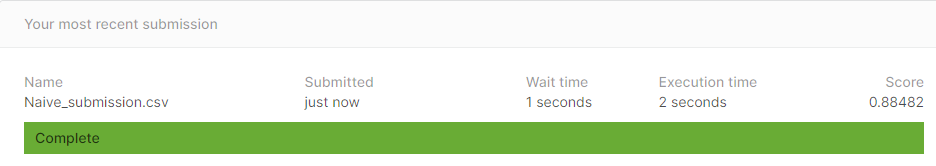

**Random Forest**
<br> Each decision tree we require a bootstrap sample. Here we are using class_weight='balanced_subsample' which automatically adjust weights inversely proportional to each bootstrap sample's class frequency instead of taking at the entire class distribution frequency into account.
https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html

In [21]:
forest=RandomForestClassifier(class_weight='balanced',n_jobs=-1)
param_grid={'max_depth': [5,10,20,35]}
clf = GridSearchCV(forest,param_grid,cv=5,scoring='precision',verbose=3,return_train_score=True)
clf.fit(x_train , y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=5 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... max_depth=5, score=(train=0.262, test=0.249), total= 2.3min
[CV] max_depth=5 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


[CV] ..... max_depth=5, score=(train=0.259, test=0.244), total= 2.1min
[CV] max_depth=5 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.4min remaining:    0.0s


[CV] ..... max_depth=5, score=(train=0.259, test=0.240), total= 2.0min
[CV] max_depth=5 .....................................................
[CV] ..... max_depth=5, score=(train=0.251, test=0.235), total= 2.0min
[CV] max_depth=5 .....................................................
[CV] ..... max_depth=5, score=(train=0.250, test=0.236), total= 2.0min
[CV] max_depth=10 ....................................................
[CV] .... max_depth=10, score=(train=0.698, test=0.395), total= 3.7min
[CV] max_depth=10 ....................................................
[CV] .... max_depth=10, score=(train=0.682, test=0.392), total= 3.7min
[CV] max_depth=10 ....................................................
[CV] .... max_depth=10, score=(train=0.683, test=0.384), total= 3.7min
[CV] max_depth=10 ....................................................
[CV] .... max_depth=10, score=(train=0.669, test=0.389), total= 3.7min
[CV] max_depth=10 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 96.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              r

In [22]:
b=clf.best_params_
print(b)
print('Precision score= ', clf.best_score_)

{'max_depth': 10}
Precision score=  0.3937596063667698


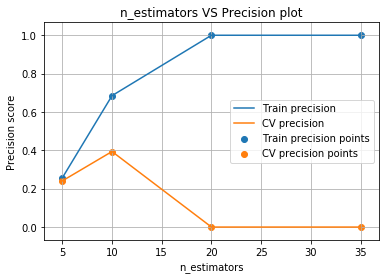

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Precision score=  0.3937596063667698


In [23]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])
train_precision= results['mean_train_score']
cv_precision = results['mean_test_score']
C =  results['param_max_depth']

plt.plot(C,train_precision, label='Train precision')
plt.plot(C,cv_precision, label='CV precision')
plt.scatter(C, train_precision, label='Train precision points')
plt.scatter(C, cv_precision,label='CV precision points')

plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("Precision score")
plt.title("n_estimators VS Precision plot")
plt.grid()
plt.show()
b=clf.best_estimator_
print(b)
print('Precision score= ', clf.best_score_)

In [14]:
rf=RandomForestClassifier(n_estimators=200,max_depth=10,class_weight='balanced_subsample',n_jobs=-1,oob_score=True,max_samples=0.4,verbose=3)
rf.fit(x_train,y_train)
y_train_pred = rf.predict_proba(x_train)
y_test_pred = rf.predict_proba(x_v)
y_tpred=rf.predict(x_v)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200building tree 2 of 200building tree 3 of 200building tree 4 of 200



building tree 5 of 200
building tree 6 of 200building tree 7 of 200

building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   41.2s


building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200building tree 36 of 200

building tree 37 of 200
building tree 38 of 200building tree 39 of 200

building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200building tree 44 of 200

building tree 45 of 200
building tree 46 of 200building tree 47 of 200

building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.4min


building tree 125 of 200
building tree 126 of 200
building tree 127 of 200building tree 128 of 200

building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200building tree 148 of 200

building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.5s finished


The precision score on test data=  0.4782816229116945


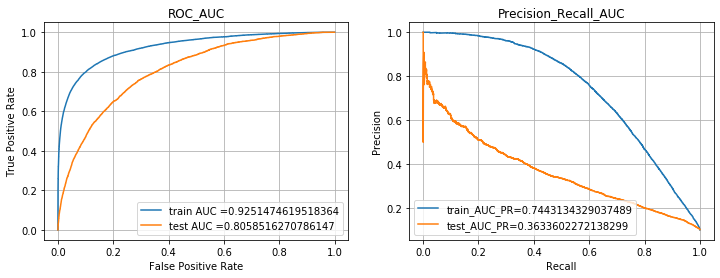

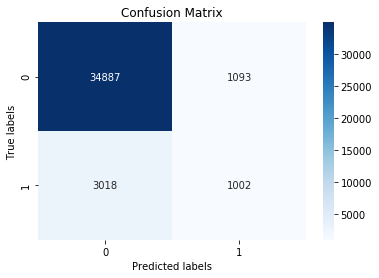

In [15]:
plot_conclusions(y_train, y_v, y_train_pred , y_test_pred,y_tpred)

In [15]:
#for kaggle submission
rfdata=pd.DataFrame()
rfdata['ID_Code']=test_df['ID_code']
rfdata['target']=rf.predict_proba(x_test)[:,1]
rfdata.to_csv('Randomforest_submission.csv',index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    8.2s finished


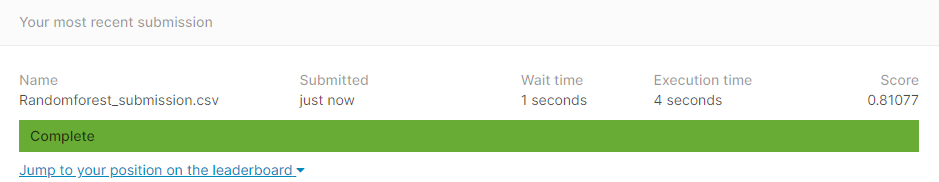

**Balanced RandomForest**
<br>It resamples data for each of the boot strap samples using random under-sampling of the majority class to create balanced subsamples

In [7]:
brf=BalancedRandomForestClassifier(oob_score=True,replacement=True,max_samples=0.4)
param_grid={'n_estimators':[200,300,500],'max_depth': [15,20]}
clf = GridSearchCV(brf,param_grid,cv=5,scoring='precision',verbose=3,n_jobs=-1,return_train_score=True)
clf.fit(x_train , y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=BalancedRandomForestClassifier(max_samples=0.4,
                                                      oob_score=True,
                                                      replacement=True),
             n_jobs=-1,
             param_grid={'max_depth': [15, 20],
                         'n_estimators': [200, 300, 500]},
             return_train_score=True, scoring='precision', verbose=3)

In [8]:
b=clf.best_params_
print(b)
print('Precision score= ', clf.best_score_)

{'max_depth': 15, 'n_estimators': 500}
Precision score=  0.2643685636613145


In [16]:
brf=BalancedRandomForestClassifier(max_depth=15,n_estimators=200,oob_score=True,replacement=True,verbose=3,max_samples=0.4,n_jobs=-1)
brf.fit(x_train,y_train)
y_train_pred = brf.predict_proba(x_train)
y_test_pred = brf.predict_proba(x_v)
y_tpred=brf.predict(x_v)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 2 of 200
building tree 3 of 200
building tree 1 of 200
building tree 4 of 200
building tree 5 of 200
building tree 7 of 200
building tree 6 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 16 of 200
building tree 15 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.3s


building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.9min


building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 147 of 200building tree 146 of 200

building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   10.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.2s finished


The precision score on test data=  0.25209796197979106


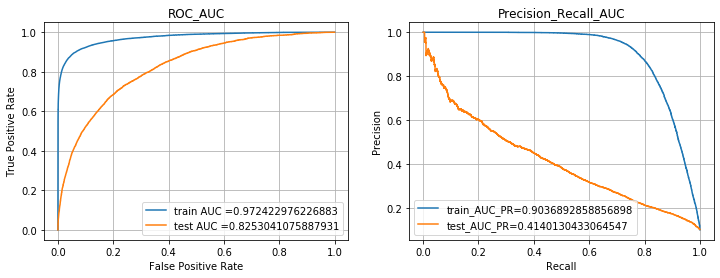

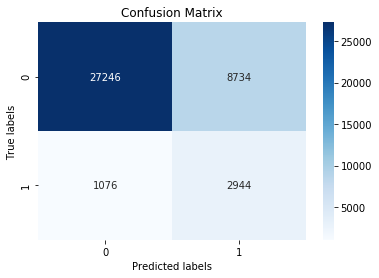

In [17]:
plot_conclusions(y_train, y_v, y_train_pred , y_test_pred,y_tpred)

In [17]:
brfdata=pd.DataFrame()
brfdata['ID_Code']=test_df['ID_code']
brfdata['target']=brf.predict_proba(x_test)[:,1]
brfdata.to_csv('BalancedRandomforest_submission.csv',index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   11.8s finished


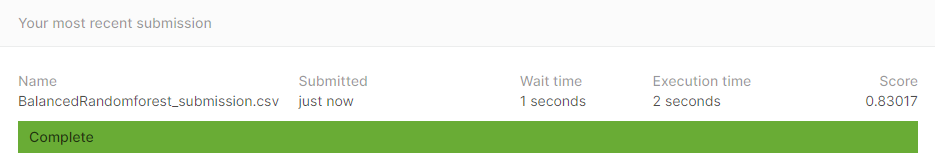

**Easy Ensemble Classifier (ADABoost)**
<br>It also creates several subset of data which are balanced by using random undersampling technique on majority class and applies ADABoost on each subset.

In [7]:
easy=EasyEnsembleClassifier(n_estimators=50,sampling_strategy='majority',random_state=42,replacement=True,verbose=3,n_jobs=-1)
easy.fit(x_train,y_train)
y_train_pred = easy.predict_proba(x_train)
y_test_pred = easy.predict_proba(x_v)
y_tpred=easy.predict(x_v)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 47.8min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min finished


The precision score on test data=  0.2578862947781144


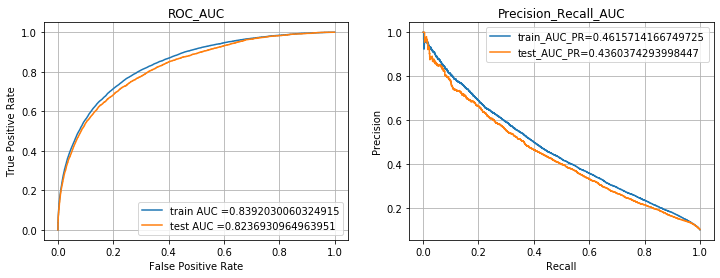

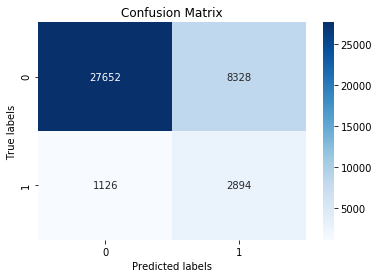

In [19]:
plot_conclusions(y_train, y_v, y_train_pred , y_test_pred,y_tpred)

In [8]:
edata=pd.DataFrame()
edata['ID_Code']=test_df['ID_code']
edata['target']=easy.predict_proba(x_test)[:,1]
edata.to_csv('easyensemble_submission.csv',index=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  6.5min finished


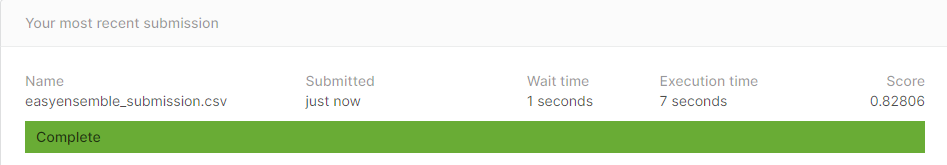

**XGBoost**

In [13]:
from collections import Counter
cnt= Counter(y_train)
print('ratio= ',cnt[0]/cnt[1])

ratio=  8.95148650329643


In [14]:
#Hyper-parameter tuning
xb = XGBClassifier(max_depth=5,eta=0.05,booster='gbtree',subsample=0.4,colsample_bytree=0.5,tree_method='gpu_hist',eval_metric='aucpr')
param_grid={'n_estimators':[200,300,400],'scale_pos_weight':[8,20,100]}
clf = GridSearchCV(xb,param_grid,cv=5,scoring='precision',verbose=3,return_train_score=True)
clf.fit(x_train , y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[20:55:34] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[20:55:37] ======== Monitor: SketchContainer ========
[20:55:37] MakeCuts: 0.007656s, 1 calls @ 7656us

[20:55:37] Prune: 0.005039s, 1 calls @ 5039us

[20:55:37] ScanInput: 0.040252s, 1 calls @ 40252us

[20:55:37] Unique: 0.002611s, 1 calls @ 2611us

[20:56:07] ======== Monitor: Learner ========
[20:56:07] Configure: 0.004525s, 1 calls @ 4525us

[20:56:07] EvalOneIter: 0.003976s, 200 calls @ 3976us

[20:56:07] GetGradient: 0.114357s, 200 calls @ 114357us

[20:56:07] PredictRaw: 1.55393s, 200 calls @ 1553931us

[20:56:07] UpdateOneIter: 32.5465s, 200 calls @ 32546530us

[20:56:07] ======== Monitor: GBTree ========
[20:56:07] BoostNewTrees: 30.3903s, 200 calls @ 30390294us

[20:56:07] CommitModel: 0.121766s, 200 calls @ 121766us

[20:56:07] ======== Device 0 Memory Allocations:  ========
[20:56:0

[20:57:27] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[20:57:28] ======== Monitor: SketchContainer ========
[20:57:28] MakeCuts: 0.008593s, 1 calls @ 8593us

[20:57:28] Prune: 0.006304s, 1 calls @ 6304us

[20:57:28] ScanInput: 0.040841s, 1 calls @ 40841us

[20:57:28] Unique: 0.003819s, 1 calls @ 3819us

[20:57:58] ======== Monitor: Learner ========
[20:57:58] Configure: 0.003946s, 1 calls @ 3946us

[20:57:58] EvalOneIter: 0.004297s, 200 calls @ 4297us

[20:57:58] GetGradient: 0.117887s, 200 calls @ 117887us

[20:57:58] PredictRaw: 0.003776s, 200 calls @ 3776us

[20:57:58] UpdateOneIter: 30.4204s, 200 calls @ 30420439us

[20:57:58] ======== Monitor: GBTree ========
[20:57:58] BoostNewTrees: 30.153s, 200 calls @ 30152963us

[20:57:58] CommitModel: 0.127505s, 200 calls @ 127505us

[20:57:58] ======== Device 0 Memory Allocations:  ========
[20:57:58] Peak memory usage: 503MiB
[20:57:58] Number of allocations: 

[20:59:16] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[20:59:17] ======== Monitor: SketchContainer ========
[20:59:17] MakeCuts: 0.008709s, 1 calls @ 8709us

[20:59:17] Prune: 0.006314s, 1 calls @ 6314us

[20:59:17] ScanInput: 0.040408s, 1 calls @ 40408us

[20:59:17] Unique: 0.003835s, 1 calls @ 3835us

[20:59:47] ======== Monitor: Learner ========
[20:59:47] Configure: 0.00549s, 1 calls @ 5490us

[20:59:47] EvalOneIter: 0.004197s, 200 calls @ 4197us

[20:59:47] GetGradient: 0.116626s, 200 calls @ 116626us

[20:59:47] PredictRaw: 0.003865s, 200 calls @ 3865us

[20:59:47] UpdateOneIter: 30.5151s, 200 calls @ 30515138us

[20:59:47] ======== Monitor: GBTree ========
[20:59:47] BoostNewTrees: 30.2518s, 200 calls @ 30251751us

[20:59:47] CommitModel: 0.123611s, 200 calls @ 123611us

[20:59:47] ======== Device 0 Memory Allocations:  ========
[20:59:47] Peak memory usage: 503MiB
[20:59:47] Number of allocations: 

[21:01:06] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:01:07] ======== Monitor: SketchContainer ========
[21:01:07] MakeCuts: 0.008789s, 1 calls @ 8789us

[21:01:07] Prune: 0.006389s, 1 calls @ 6389us

[21:01:07] ScanInput: 0.040773s, 1 calls @ 40773us

[21:01:07] Unique: 0.003702s, 1 calls @ 3702us

[21:01:37] ======== Monitor: Learner ========
[21:01:37] Configure: 0.005149s, 1 calls @ 5149us

[21:01:37] EvalOneIter: 0.004111s, 200 calls @ 4111us

[21:01:37] GetGradient: 0.120149s, 200 calls @ 120149us

[21:01:37] PredictRaw: 0.003771s, 200 calls @ 3771us

[21:01:37] UpdateOneIter: 30.717s, 200 calls @ 30717018us

[21:01:37] ======== Monitor: GBTree ========
[21:01:37] BoostNewTrees: 30.4432s, 200 calls @ 30443215us

[21:01:37] CommitModel: 0.130764s, 200 calls @ 130764us

[21:01:37] ======== Device 0 Memory Allocations:  ========
[21:01:37] Peak memory usage: 503MiB
[21:01:37] Number of allocations: 

[21:02:52] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:02:53] ======== Monitor: SketchContainer ========
[21:02:53] MakeCuts: 0.008401s, 1 calls @ 8401us

[21:02:53] Prune: 0.006329s, 1 calls @ 6329us

[21:02:53] ScanInput: 0.040543s, 1 calls @ 40543us

[21:02:53] Unique: 0.003826s, 1 calls @ 3826us

[21:03:21] ======== Monitor: Learner ========
[21:03:21] Configure: 0.005378s, 1 calls @ 5378us

[21:03:21] EvalOneIter: 0.0039s, 200 calls @ 3900us

[21:03:21] GetGradient: 0.113221s, 200 calls @ 113221us

[21:03:21] PredictRaw: 0.003691s, 200 calls @ 3691us

[21:03:21] UpdateOneIter: 28.8494s, 200 calls @ 28849408us

[21:03:21] ======== Monitor: GBTree ========
[21:03:21] BoostNewTrees: 28.5948s, 200 calls @ 28594806us

[21:03:21] CommitModel: 0.118609s, 200 calls @ 118609us

[21:03:21] ======== Device 0 Memory Allocations:  ========
[21:03:21] Peak memory usage: 503MiB
[21:03:21] Number of allocations: 3

[21:04:35] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:04:36] ======== Monitor: SketchContainer ========
[21:04:36] MakeCuts: 0.008651s, 1 calls @ 8651us

[21:04:36] Prune: 0.006309s, 1 calls @ 6309us

[21:04:36] ScanInput: 0.040427s, 1 calls @ 40427us

[21:04:36] Unique: 0.003817s, 1 calls @ 3817us

[21:05:21] ======== Monitor: Learner ========
[21:05:21] Configure: 0.005293s, 1 calls @ 5293us

[21:05:21] EvalOneIter: 0.00612s, 300 calls @ 6120us

[21:05:21] GetGradient: 0.167125s, 300 calls @ 167125us

[21:05:21] PredictRaw: 0.005075s, 300 calls @ 5075us

[21:05:21] UpdateOneIter: 45.5282s, 300 calls @ 45528179us

[21:05:21] ======== Monitor: GBTree ========
[21:05:21] BoostNewTrees: 45.1494s, 300 calls @ 45149392us

[21:05:21] CommitModel: 0.180803s, 300 calls @ 180803us

[21:05:21] ======== Device 0 Memory Allocations:  ========
[21:05:21] Peak memory usage: 503MiB
[21:05:21] Number of allocations: 

[21:07:10] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:07:11] ======== Monitor: SketchContainer ========
[21:07:11] MakeCuts: 0.007111s, 1 calls @ 7111us

[21:07:11] Prune: 0.005344s, 1 calls @ 5344us

[21:07:11] ScanInput: 0.040175s, 1 calls @ 40175us

[21:07:11] Unique: 0.003118s, 1 calls @ 3118us

[21:07:56] ======== Monitor: Learner ========
[21:07:56] Configure: 0.006157s, 1 calls @ 6157us

[21:07:56] EvalOneIter: 0.00591s, 300 calls @ 5910us

[21:07:56] GetGradient: 0.168082s, 300 calls @ 168082us

[21:07:56] PredictRaw: 0.005086s, 300 calls @ 5086us

[21:07:56] UpdateOneIter: 45.0776s, 300 calls @ 45077601us

[21:07:56] ======== Monitor: GBTree ========
[21:07:56] BoostNewTrees: 44.6985s, 300 calls @ 44698532us

[21:07:56] CommitModel: 0.179592s, 300 calls @ 179592us

[21:07:56] ======== Device 0 Memory Allocations:  ========
[21:07:56] Peak memory usage: 503MiB
[21:07:56] Number of allocations: 

[21:09:46] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:09:47] ======== Monitor: SketchContainer ========
[21:09:47] MakeCuts: 0.008997s, 1 calls @ 8997us

[21:09:47] Prune: 0.006587s, 1 calls @ 6587us

[21:09:47] ScanInput: 0.040571s, 1 calls @ 40571us

[21:09:47] Unique: 0.003883s, 1 calls @ 3883us

[21:10:31] ======== Monitor: Learner ========
[21:10:31] Configure: 0.005358s, 1 calls @ 5358us

[21:10:31] EvalOneIter: 0.006013s, 300 calls @ 6013us

[21:10:31] GetGradient: 0.16673s, 300 calls @ 166730us

[21:10:31] PredictRaw: 0.004842s, 300 calls @ 4842us

[21:10:31] UpdateOneIter: 44.868s, 300 calls @ 44867954us

[21:10:31] ======== Monitor: GBTree ========
[21:10:31] BoostNewTrees: 44.4923s, 300 calls @ 44492326us

[21:10:31] CommitModel: 0.178586s, 300 calls @ 178586us

[21:10:31] ======== Device 0 Memory Allocations:  ========
[21:10:31] Peak memory usage: 503MiB
[21:10:31] Number of allocations: 6

[21:12:20] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:12:21] ======== Monitor: SketchContainer ========
[21:12:21] MakeCuts: 0.007712s, 1 calls @ 7712us

[21:12:21] Prune: 0.005916s, 1 calls @ 5916us

[21:12:21] ScanInput: 0.040131s, 1 calls @ 40131us

[21:12:21] Unique: 0.003318s, 1 calls @ 3318us

[21:13:06] ======== Monitor: Learner ========
[21:13:06] Configure: 0.002528s, 1 calls @ 2528us

[21:13:06] EvalOneIter: 0.006112s, 300 calls @ 6112us

[21:13:06] GetGradient: 0.166738s, 300 calls @ 166738us

[21:13:06] PredictRaw: 0.004509s, 300 calls @ 4509us

[21:13:06] UpdateOneIter: 45.3718s, 300 calls @ 45371812us

[21:13:06] ======== Monitor: GBTree ========
[21:13:06] BoostNewTrees: 44.9962s, 300 calls @ 44996199us

[21:13:06] CommitModel: 0.181417s, 300 calls @ 181417us

[21:13:06] ======== Device 0 Memory Allocations:  ========
[21:13:06] Peak memory usage: 503MiB
[21:13:06] Number of allocations:

[21:14:52] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:14:53] ======== Monitor: SketchContainer ========
[21:14:53] MakeCuts: 0.009183s, 1 calls @ 9183us

[21:14:53] Prune: 0.006795s, 1 calls @ 6795us

[21:14:53] ScanInput: 0.040093s, 1 calls @ 40093us

[21:14:53] Unique: 0.003829s, 1 calls @ 3829us

[21:15:35] ======== Monitor: Learner ========
[21:15:35] Configure: 0.003623s, 1 calls @ 3623us

[21:15:35] EvalOneIter: 0.005943s, 300 calls @ 5943us

[21:15:35] GetGradient: 0.164434s, 300 calls @ 164434us

[21:15:35] PredictRaw: 0.004564s, 300 calls @ 4564us

[21:15:35] UpdateOneIter: 43.0813s, 300 calls @ 43081254us

[21:15:35] ======== Monitor: GBTree ========
[21:15:35] BoostNewTrees: 42.7101s, 300 calls @ 42710091us

[21:15:35] CommitModel: 0.178473s, 300 calls @ 178473us

[21:15:35] ======== Device 0 Memory Allocations:  ========
[21:15:35] Peak memory usage: 503MiB
[21:15:35] Number of allocations:

[21:17:21] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:17:22] ======== Monitor: SketchContainer ========
[21:17:22] MakeCuts: 0.007899s, 1 calls @ 7899us

[21:17:22] Prune: 0.005803s, 1 calls @ 5803us

[21:17:22] ScanInput: 0.04045s, 1 calls @ 40450us

[21:17:22] Unique: 0.003293s, 1 calls @ 3293us

[21:18:23] ======== Monitor: Learner ========
[21:18:23] Configure: 0.005174s, 1 calls @ 5174us

[21:18:23] EvalOneIter: 0.008268s, 400 calls @ 8268us

[21:18:23] GetGradient: 0.225529s, 400 calls @ 225529us

[21:18:23] PredictRaw: 0.00642s, 400 calls @ 6420us

[21:18:23] UpdateOneIter: 60.8953s, 400 calls @ 60895334us

[21:18:23] ======== Monitor: GBTree ========
[21:18:23] BoostNewTrees: 60.3796s, 400 calls @ 60379626us

[21:18:23] CommitModel: 0.250571s, 400 calls @ 250571us

[21:18:23] ======== Device 0 Memory Allocations:  ========
[21:18:23] Peak memory usage: 503MiB
[21:18:23] Number of allocations: 9

[21:20:44] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:20:45] ======== Monitor: SketchContainer ========
[21:20:45] MakeCuts: 0.007433s, 1 calls @ 7433us

[21:20:45] Prune: 0.005707s, 1 calls @ 5707us

[21:20:45] ScanInput: 0.040467s, 1 calls @ 40467us

[21:20:45] Unique: 0.003215s, 1 calls @ 3215us

[21:21:46] ======== Monitor: Learner ========
[21:21:46] Configure: 0.005212s, 1 calls @ 5212us

[21:21:46] EvalOneIter: 0.008546s, 400 calls @ 8546us

[21:21:46] GetGradient: 0.223887s, 400 calls @ 223887us

[21:21:46] PredictRaw: 0.00661s, 400 calls @ 6610us

[21:21:46] UpdateOneIter: 60.4474s, 400 calls @ 60447389us

[21:21:46] ======== Monitor: GBTree ========
[21:21:46] BoostNewTrees: 59.9339s, 400 calls @ 59933861us

[21:21:46] CommitModel: 0.250107s, 400 calls @ 250107us

[21:21:46] ======== Device 0 Memory Allocations:  ========
[21:21:46] Peak memory usage: 503MiB
[21:21:46] Number of allocations: 

[21:24:08] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:24:09] ======== Monitor: SketchContainer ========
[21:24:09] MakeCuts: 0.008967s, 1 calls @ 8967us

[21:24:09] Prune: 0.006575s, 1 calls @ 6575us

[21:24:09] ScanInput: 0.040911s, 1 calls @ 40911us

[21:24:09] Unique: 0.003774s, 1 calls @ 3774us

[21:25:08] ======== Monitor: Learner ========
[21:25:08] Configure: 0.005201s, 1 calls @ 5201us

[21:25:08] EvalOneIter: 0.007923s, 400 calls @ 7923us

[21:25:08] GetGradient: 0.22152s, 400 calls @ 221520us

[21:25:08] PredictRaw: 0.006166s, 400 calls @ 6166us

[21:25:08] UpdateOneIter: 59.9194s, 400 calls @ 59919357us

[21:25:08] ======== Monitor: GBTree ========
[21:25:08] BoostNewTrees: 59.4188s, 400 calls @ 59418800us

[21:25:08] CommitModel: 0.240549s, 400 calls @ 240549us

[21:25:08] ======== Device 0 Memory Allocations:  ========
[21:25:08] Peak memory usage: 503MiB
[21:25:08] Number of allocations: 

[21:27:29] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:27:30] ======== Monitor: SketchContainer ========
[21:27:30] MakeCuts: 0.009067s, 1 calls @ 9067us

[21:27:30] Prune: 0.006642s, 1 calls @ 6642us

[21:27:30] ScanInput: 0.040047s, 1 calls @ 40047us

[21:27:30] Unique: 0.003792s, 1 calls @ 3792us

[21:28:30] ======== Monitor: Learner ========
[21:28:30] Configure: 0.005942s, 1 calls @ 5942us

[21:28:30] EvalOneIter: 0.007841s, 400 calls @ 7841us

[21:28:30] GetGradient: 0.222338s, 400 calls @ 222338us

[21:28:30] PredictRaw: 0.006316s, 400 calls @ 6316us

[21:28:30] UpdateOneIter: 60.1449s, 400 calls @ 60144886us

[21:28:30] ======== Monitor: GBTree ========
[21:28:30] BoostNewTrees: 59.6431s, 400 calls @ 59643081us

[21:28:30] CommitModel: 0.240436s, 400 calls @ 240436us

[21:28:30] ======== Device 0 Memory Allocations:  ========
[21:28:30] Peak memory usage: 503MiB
[21:28:30] Number of allocations:

[21:30:47] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:30:48] ======== Monitor: SketchContainer ========
[21:30:48] MakeCuts: 0.008776s, 1 calls @ 8776us

[21:30:48] Prune: 0.00644s, 1 calls @ 6440us

[21:30:48] ScanInput: 0.040669s, 1 calls @ 40669us

[21:30:48] Unique: 0.003804s, 1 calls @ 3804us

[21:31:45] ======== Monitor: Learner ========
[21:31:45] Configure: 0.003676s, 1 calls @ 3676us

[21:31:45] EvalOneIter: 0.00796s, 400 calls @ 7960us

[21:31:45] GetGradient: 0.21882s, 400 calls @ 218820us

[21:31:45] PredictRaw: 0.006162s, 400 calls @ 6162us

[21:31:45] UpdateOneIter: 57.1273s, 400 calls @ 57127287us

[21:31:45] ======== Monitor: GBTree ========
[21:31:45] BoostNewTrees: 56.6337s, 400 calls @ 56633669us

[21:31:45] CommitModel: 0.237812s, 400 calls @ 237812us

[21:31:45] ======== Device 0 Memory Allocations:  ========
[21:31:45] Peak memory usage: 503MiB
[21:31:45] Number of allocations: 15

[21:34:02] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:892: [GPU Hist]: Configure
[21:34:03] ======== Monitor: SketchContainer ========
[21:34:03] MakeCuts: 0.007719s, 1 calls @ 7719us

[21:34:03] Prune: 0.005954s, 1 calls @ 5954us

[21:34:03] ScanInput: 0.051481s, 1 calls @ 51481us

[21:34:03] Unique: 0.003332s, 1 calls @ 3332us

[21:35:13] ======== Monitor: Learner ========
[21:35:13] Configure: 0.005479s, 1 calls @ 5479us

[21:35:13] EvalOneIter: 0.008286s, 400 calls @ 8286us

[21:35:13] GetGradient: 0.243471s, 400 calls @ 243471us

[21:35:13] PredictRaw: 0.00676s, 400 calls @ 6760us

[21:35:13] UpdateOneIter: 69.9121s, 400 calls @ 69912085us

[21:35:13] ======== Monitor: GBTree ========
[21:35:13] BoostNewTrees: 69.3481s, 400 calls @ 69348111us

[21:35:13] CommitModel: 0.279723s, 400 calls @ 279723us

[21:35:13] ======== Device 0 Memory Allocations:  ========
[21:35:13] Peak memory usage: 503MiB
[21:35:13] Number of allocations: 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, eta=0.05,
                                     eval_metric='aucpr', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=5, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, su

In [15]:
b=clf.best_params_
print(b)
print('Precision score= ', clf.best_score_)

{'n_estimators': 400, 'scale_pos_weight': 8}
Precision score=  0.40539244843628836


In [9]:
#eta=learning rate
xgb=XGBClassifier(max_depth=4,n_estimators=600,eta=0.1,booster='gbtree',subsample=0.4,verbosity=2,scale_pos_weight=8,colsample_bytree=0.2,tree_method='gpu_hist',eval_metric='aucpr')
xgb.fit(x_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, eta=0.1,
              eval_metric='aucpr', gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.100000001,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=8, subsample=0.4, tree_method='gpu_hist',
              validate_parameters=1, verbosity=2)

The precision score on test data=  0.39107505070993914


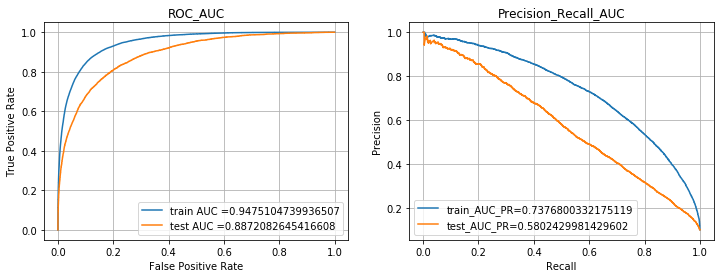

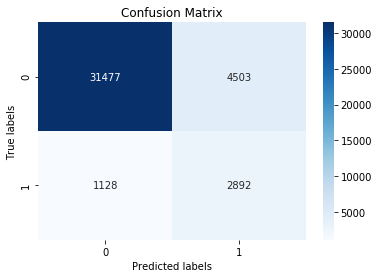

In [12]:
y_train_pred = xgb.predict_proba(x_train)
y_test_pred = xgb.predict_proba(x_v)
y_tpred=xgb.predict(x_v)
plot_conclusions(y_train, y_v, y_train_pred , y_test_pred,y_tpred)

In [40]:
xdata=pd.DataFrame()
xdata['ID_Code']=test_df['ID_code']
xdata['target']=xgb.predict_proba(x_test)[:,1]
xdata.to_csv('XGB_submission.csv',index=False)

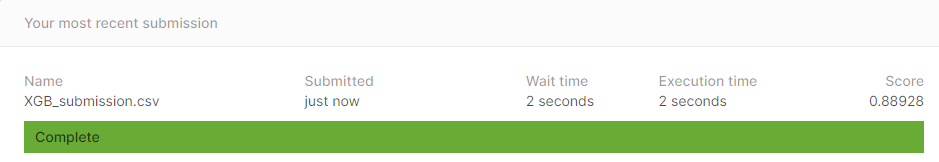

In [13]:
#www.kaggle.com/prmohanty/python-how-to-save-and-load-ml-models
import pickle
filename='final_model.pkl'
with open(filename,'wb') as file:
    pickle.dump(xgb,file)

**NEURAL NETWORK**

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau,EarlyStopping,TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
import os,datetime

In [48]:
lr_new= ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=5,verbose=1,mode='auto')
earlystop = EarlyStopping(monitor='val_loss',patience=30, verbose=1)
metric=tf.keras.metrics.AUC(num_thresholds=50, curve='ROC')
#LeakyReLU(alpha=0.01)

In [49]:
ini=tf.keras.initializers.HeUniform()
model= keras.Sequential()
model.add(tf.keras.Input(shape=x_train.shape[1],))
model.add(Dense(64,activation=LeakyReLU(),name='Layer1',kernel_initializer=ini))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(32,activation=LeakyReLU(),name='Layer2',kernel_initializer=ini))
model.add(Dropout(0.1))
model.add(Dense(16,activation=LeakyReLU(),name='Layer3',kernel_initializer=ini))
model.add(BatchNormalization())
model.add(Dense(8,activation=LeakyReLU(),name='Layer4',kernel_initializer=ini))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(8,activation=LeakyReLU(),name='Layer5',kernel_initializer=ini))
model.add(Dense(1,activation="sigmoid"))
opt=tf.keras.optimizers.Adam(learning_rate=0.01)
weights={0:1,1:8}

model.compile(optimizer=opt,loss='BinaryCrossentropy',metrics=[metric,'Precision'])

log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

callback_list=[lr_new,earlystop,tensorboard_callback]

model.fit(x_train,y_train,class_weight=weights,epochs=200,validation_data=(x_v,y_v),batch_size=1000,callbacks=callback_list)

Epoch 1/200
160/160 [==============================] - 24s 115ms/step - loss: 0.9102 - auc_3: 0.8057 - precision: 0.2406 - val_loss: 0.5410 - val_auc_3: 0.8601 - val_precision: 0.2529
Epoch 2/200
160/160 [==============================] - 15s 94ms/step - loss: 0.7804 - auc_3: 0.8641 - precision: 0.3021 - val_loss: 0.4506 - val_auc_3: 0.8624 - val_precision: 0.2823
Epoch 3/200
160/160 [==============================] - 15s 96ms/step - loss: 0.7660 - auc_3: 0.8697 - precision: 0.3057 - val_loss: 0.4813 - val_auc_3: 0.8610 - val_precision: 0.2648
Epoch 4/200
160/160 [==============================] - 15s 93ms/step - loss: 0.7639 - auc_3: 0.8703 - precision: 0.2980 - val_loss: 0.4096 - val_auc_3: 0.8628 - val_precision: 0.2938
Epoch 5/200
160/160 [==============================] - 17s 107ms/step - loss: 0.7572 - auc_3: 0.8740 - precision: 0.3025 - val_loss: 0.4383 - val_auc_3: 0.8618 - val_precision: 0.2817
Epoch 6/200
160/160 [==============================] - 22s 138ms/step - loss: 0.751

160/160 [==============================] - 13s 82ms/step - loss: 0.5784 - auc_3: 0.9249 - precision: 0.3558 - val_loss: 0.3554 - val_auc_3: 0.8479 - val_precision: 0.3270

Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.
Epoch 00083: early stopping


In [ ]:
y_train_pred = model.predict_proba(x_train)
y_test_pred = model.predict_proba(x_v)
y_tpred=model.predict(x_v)
#plot_conclusions(y_train, y_v, y_train_pred , y_test_pred,y_tpred)

In [57]:
for i in range(len(y_tpred)):
    if y_tpred[i]>0.5:
        y_tpred[i]=1
    else:
        y_tpred[i]=0

The precision score on test data=  0.32701532701532704


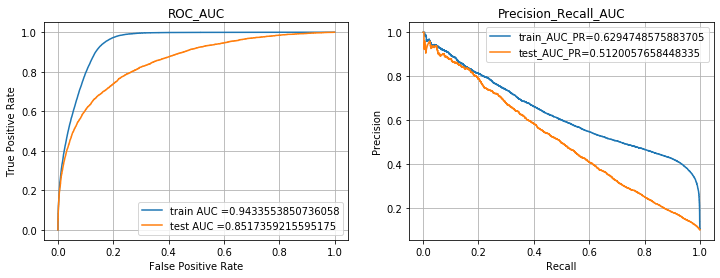

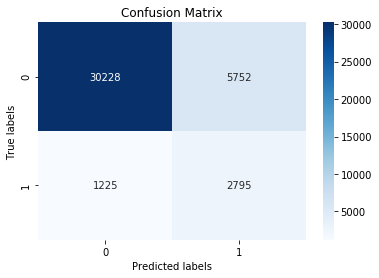

In [59]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_v, y_test_pred)

train_pre,train_re,tr_threshold=precision_recall_curve(y_train, y_train_pred)
test_pre,test_re,te_threshold=precision_recall_curve(y_v, y_test_pred)
print('The precision score on test data= ',precision_score(y_v,y_tpred))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('ROC_AUC')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.grid()
plt.legend()
  
plt.subplot(1,2,2)
plt.title('Precision_Recall_AUC')
plt.plot(train_re,train_pre,label='train_AUC_PR='+str(auc(train_re,train_pre)))
plt.plot(test_re,test_pre,label='test_AUC_PR='+str(auc(test_re,test_pre)))
plt.xlabel('Recall')
plt.ylabel("Precision")
plt.grid()
plt.legend()

plt.figure(2)
conf_mat=confusion_matrix(y_v,y_tpred)
ax=plt.subplot()
sns.heatmap(conf_mat,fmt='d',annot=True,cmap='Blues',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0','1']) 
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

In [56]:
nndata=pd.DataFrame()
nndata['ID_Code']=test_df['ID_code']
nndata['target']=model.predict_proba(x_test)
nndata.to_csv('ANN_submission.csv',index=False)

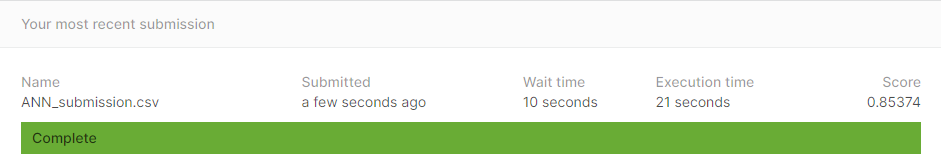

In [3]:
from prettytable import PrettyTable  
x = PrettyTable()
x.field_names = ['MODEL','Precision','ROC_AUC','AUC_PR']
x.add_row(['Baseline Model',_,0.499,0.144])
x.add_row(['Logistic Regression',0.292,0.865,0.523])
x.add_row(['Gaussian Naive Bayes',0.846,0.884,0.558])
x.add_row(['Random Forest',0.478,0.805,0.363])
x.add_row(['Balanced Random forest',0.252,0.825,0.414])
x.add_row(['Easy enseamble',0.257,0.823,0.436])
x.add_row(['XGBoost(estimators=600)',0.39,0.887,0.580])
x.add_row(['ANN',0.32,0.851,0.512])
print(x)

+-------------------------+-----------+---------+--------+
|          MODEL          | Precision | ROC_AUC | AUC_PR |
+-------------------------+-----------+---------+--------+
|      Baseline Model     |           |  0.499  | 0.144  |
|   Logistic Regression   |   0.292   |  0.865  | 0.523  |
|   Gaussian Naive Bayes  |   0.846   |  0.884  | 0.558  |
|      Random Forest      |   0.478   |  0.805  | 0.363  |
|  Balanced Random forest |   0.252   |  0.825  | 0.414  |
|      Easy enseamble     |   0.257   |  0.823  | 0.436  |
| XGBoost(estimators=600) |    0.39   |  0.887  |  0.58  |
|           ANN           |    0.32   |  0.851  | 0.512  |
+-------------------------+-----------+---------+--------+


**LightGBM on each individual column + it's feature column**

In [4]:
#column names
fea_names=np.array([x for x in train_df_new.drop(labels=['ID_code','target'],axis=1).columns])

In [8]:
xnew_train=train_df_new.drop(['ID_code','target'],axis=1)
ynew_train=train_df_new['target'].values
xnew_train,xnew_v,ynew_train,ynew_v= train_test_split(xnew_train, ynew_train, test_size=0.2, stratify=ynew_train,random_state=0) #splitting into train and validation set
print(xnew_train.shape,ynew_train.shape)

xnew_test=test_df_new.drop(['ID_code'],axis=1)

(160000, 200) (160000,)


In [6]:
val_freq={fea:xnew_train[fea].value_counts() for fea in fea_names}

In [7]:
#https://github.com/microsoft/LightGBM/issues/695#issuecomment-315591634
#https://lightgbm.readthedocs.io/en/latest/Parameters.html
params={ 
    'objective':'binary',
    'metric':'auc',
    'n_estimators':40,
    'learning_rate':0.05,
    #'scale_pos_weight':8,
    #'max_bin':165,
    'max_depth':5,
    'num_leaves':6,
    #'lambda_l1':1,
    'lambda_l2':1,
    'min_child_weight':0.1
}

In [9]:
predict_cv= 0
predict_test=0

lgb=LGBMClassifier(**params,n_jobs=-1,verbose=1)
for fea in fea_names:
    
    x=np.hstack([xnew_train[fea].values.reshape(-1,1), xnew_train[fea].map(val_freq[fea]).values.reshape(-1,1)])
    
    x_var=np.hstack([xnew_v[fea].values.reshape(-1,1), xnew_v[fea].map(val_freq[fea]).values.reshape(-1,1)])
    x_var[:,1] = x_var[:,1] + 1
    x_var[:,1][np.isnan(x_var[:,1])]=1
    
    xt=np.hstack([xnew_test[fea].values.reshape(-1,1), xnew_test[fea].map(val_freq[fea]).values.reshape(-1,1)])
    #we are mapping values from train set and  if that value is also present in test set we are adding 1
    #which ever value map doesn't find it fills it with nan(float),but as we are observing it in test set so we put 1 in place of nan 
    xt[:,1] = xt[:,1] + 1      
    xt[:,1][np.isnan(xt[:,1])]=1
    
    lgb.fit(x , ynew_train)
    predict_cv +=logit(lgb.predict_proba(x_var)[:,1])    #predicting on CV set to check score
    
    predict_test +=logit(lgb.predict_proba(xt)[:,1]) #predicting on test set

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 1

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the ov

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the ov

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 1

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choos

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choos

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choos

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005137 seconds.
You can set `force_col_w

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points i

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choos

[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[L

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choos

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choos

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 1

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004941 seconds.
You can set `force_col_w

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 1

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100487 -> initscore=-2.191820
[LightGBM] [Info] Start training from score -2.191820
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choos

In [10]:
from sklearn.metrics import roc_auc_score
score=roc_auc_score(ynew_v,predict_cv)
print('cv_score=',score)

cv_score= 0.90819307437244



predi=0
for fea in fea_names:
    xt=np.hstack([xnew_test[fea].values.reshape(-1,1), xnew_test[fea].map(val_freq[fea]).values.reshape(-1,1)])
    xt[:,1] = xt[:,1] + 1
    xt[:,1][np.isnan(xt[:,1])]=1
    predi +=logit(lgb.predict_proba(xt)[:,1])

In [12]:
ldata=pd.DataFrame()
ldata['ID_Code']=test_df['ID_code']
ldata['target']=predict_test
ldata.to_csv('lgbpredi4_submission.csv',index=False)

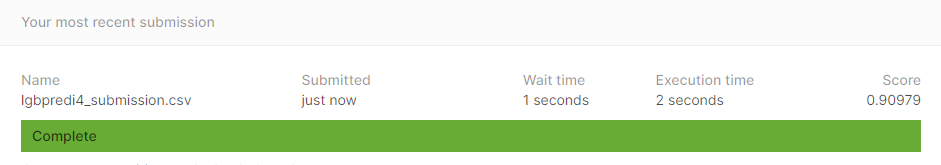
